In [1]:
import modulus.sym
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra.utils import compose
from modulus.sym.hydra.config import ModulusConfig

cfg = compose(config_path="conf", config_name="config")
cfg.network_dir = 'outputs'    # Set the network directory for checkpoints
print(to_yaml(cfg))

/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/modulus/sym/hydra/utils.py:148: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(
TorchScript default is being turned off due to PyTorch version mismatch.


training:
  max_steps: 10000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: ${training.rec_results_freq}
  rec_inference_freq: ${training.rec_results_freq}
  rec_monitor_freq: ${training.rec_results_freq}
  rec_constraint_freq: 1000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
graph:
  func_arch: false
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk,npz
summary_histograms: false
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: true
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: false
run_mode: train
arch:

In [2]:
from sympy import Symbol
from modulus.sym.geometry.primitives_1d import Line1D

# make geometry
x = Symbol("x")
geo = Line1D(0, 1)

Boundary Samples {'x': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.]]), 'normal_x': array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]]), 'area': array([[0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ]])}


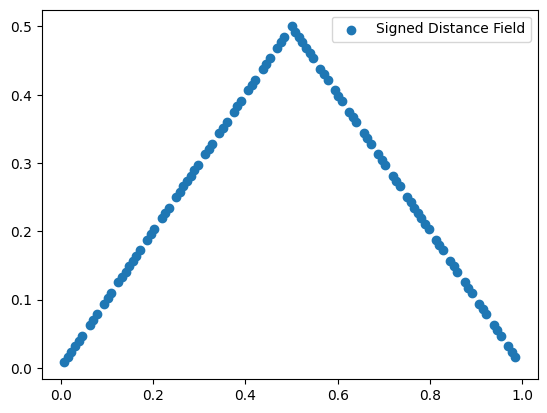

In [3]:
samples = geo.sample_boundary(10, quasirandom=True)
print("Boundary Samples", samples)

samples = geo.sample_interior(100, quasirandom=True)
# print("Interior Samples", samples)

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(samples['x'], samples['sdf'], label='Signed Distance Field')
plt.legend()
plt.show()

In [4]:
from sympy import Symbol, Number, Function
from modulus.sym.eq.pde import PDE

class CustomPDE(PDE):
    def __init__(self, f=1.0):
        # coordinates
        x = Symbol("x")

        # make input variables
        input_variables = {"x": x}

        # make u function
        u = Function("u")(*input_variables)

        # source term
        if type(f) is str:
            f = Function(f)(*input_variables)
        elif type(f) in [float, int]:
            f = Number(f)

        # set equations
        self.equations = {}
        self.equations["custom_pde"] = (
            u.diff(x, 2) - f
        )  # "custom_pde" key name will be used in constraints

In [5]:
from modulus.sym.models.fully_connected import FullyConnectedArch
from modulus.sym.key import Key

# make list of nodes to unroll graph on
eq = CustomPDE(f=1.0)
u_net = FullyConnectedArch(
    input_keys=[Key("x")], output_keys=[Key("u")], nr_layers=3, layer_size=32
)

nodes = eq.make_nodes() + [u_net.make_node(name="u_network")]

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=1, out_features=32, bias=True)
      )
      (1-2): 2 x FCLayer(
        (linear): WeightNormLinear(in_features=32, out_features=32, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)
custom_pde: u__x__x - 1.0
None


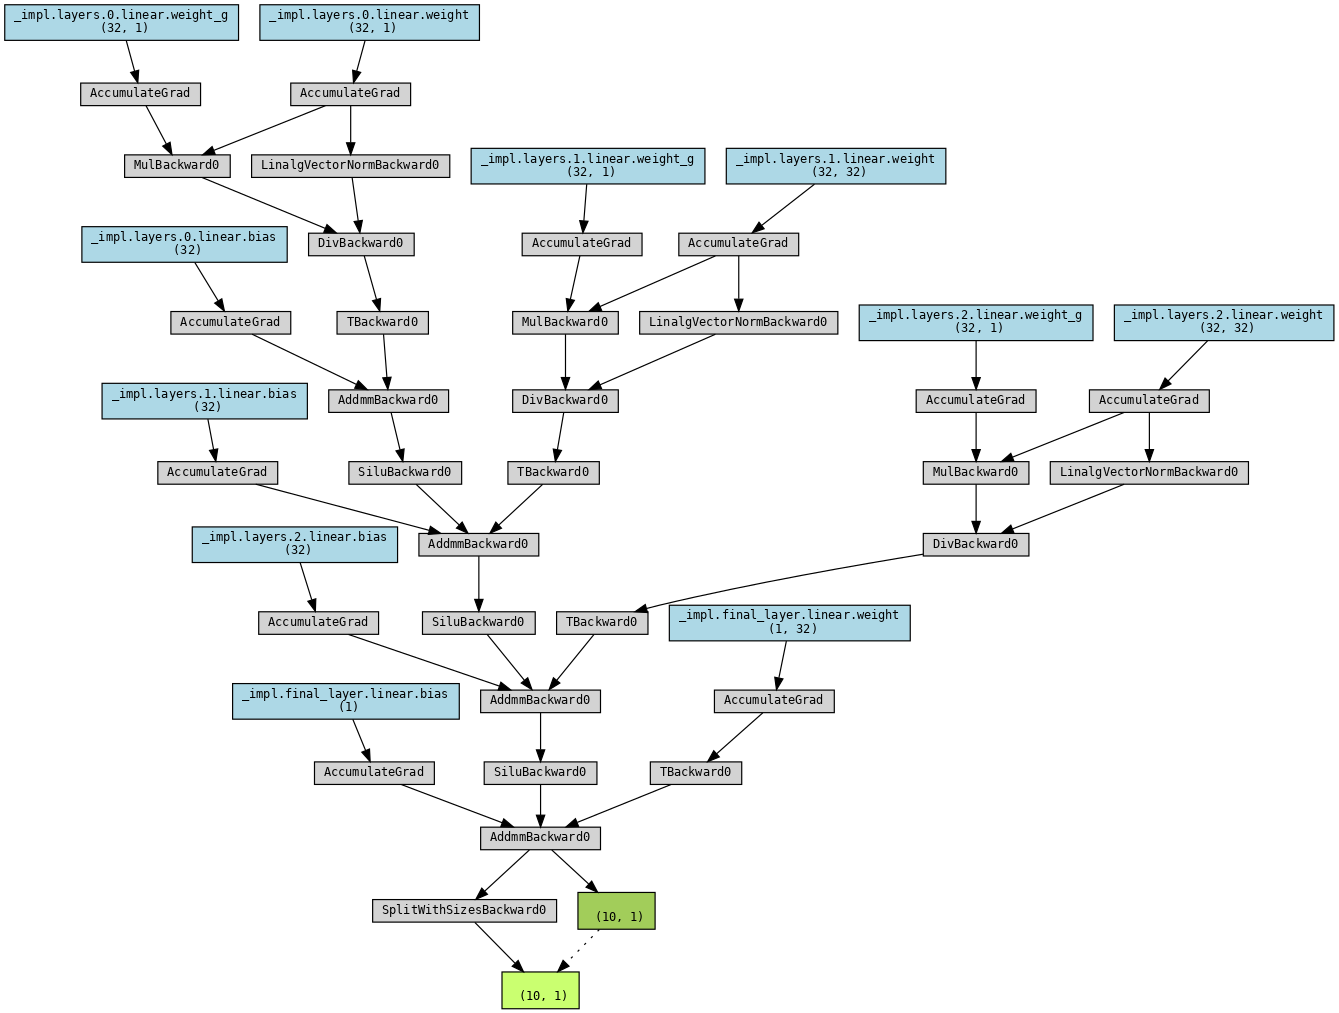

In [6]:
# visualize the network and symbolic equation in Modulus Sym:
print(u_net)
print(eq.pprint())

# graphically visualize the PyTorch execution graph
import torch
from torchviz import make_dot
from IPython.display import Image

# pass dummy data through the model
data_out = u_net({"x": (torch.rand(10, 1)),})
make_dot(data_out["u"], params=dict(u_net.named_parameters())).render("u_network", format="png")
display(Image(filename='./u_network.png'))

In [7]:
from modulus.sym.domain import Domain

# make domain
domain = Domain()
domain

In [8]:
from modulus.sym.domain.constraint import PointwiseBoundaryConstraint, PointwiseInteriorConstraint

# bcs
bc = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"u": 0},
    batch_size=2,
)
domain.add_constraint(bc, "bc")

# interior
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"custom_pde": 0},
    batch_size=100,
    bounds={x: (0, 1)},
)
domain.add_constraint(interior, "interior")

In [9]:
import numpy as np
from modulus.sym.domain.inferencer import PointwiseInferencer

# add inferencer
inference = PointwiseInferencer(
    nodes=nodes,
    invar={"x": np.linspace(0, 1.0, 100).reshape(-1,1)},
    output_names=["u"],
)
domain.add_inferencer(inference, "inf_data")

In [10]:
# to make the logging work in the jupyter cells
# execute this cell only once
import logging
logging.getLogger().addHandler(logging.StreamHandler())

In [13]:
import os
from modulus.sym.solver import Solver

# optional
# set appropriate GPU in case of multi-GPU machine
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

# make solver
slv = Solver(cfg, domain)

# start solver
slv.solve()

Installed PyTorch version 2.2.0+cu121 is not TorchScript supported in Modulus. Version 2.1.0a0+4136153 is officially supported.
attempting to restore from: /home/mitch/PythonProjects/explosics-learn/tutorials/nb/outputs
optimizer checkpoint not found
model u_network.0.pth not found
[step:          0] saved constraint results to outputs
[step:          0] record constraint batch time:  2.238e-02s
[step:          0] saved inferencer results to outputs
[step:          0] record inferencers time:  2.911e-03s
[step:          0] saved checkpoint to /home/mitch/PythonProjects/explosics-learn/tutorials/nb/outputs
[step:          0] loss:  1.417e-01
Attempting cuda graph building, this may take a bit...
[step:        100] loss:  1.204e-05, time/iteration:  1.088e+02 ms
[step:        200] loss:  3.351e-06, time/iteration:  2.937e+00 ms
[step:        300] loss:  2.603e-06, time/iteration:  2.872e+00 ms
[step:        400] loss:  2.122e-06, time/iteration:  2.878e+00 ms
[step:        500] loss:  1.

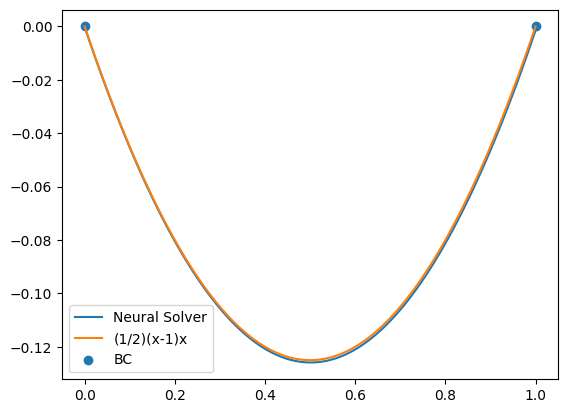

In [11]:
import matplotlib.pyplot as plt
import numpy as np
data = np.load('./outputs/inferencers/inf_data.npz', allow_pickle=True)
data = np.atleast_1d(data.f.arr_0)[0]
plt.figure()
x = data['x'].flatten()
pred_u = data['u'].flatten()
plt.plot(np.sort(x), pred_u[np.argsort(x)], label='Neural Solver')
plt.plot(np.sort(x), 0.5*(np.sort(x)*(np.sort(x)-1)), label='(1/2)(x-1)x')
x_np = np.array([0., 1.])
u_np = 0.5*(x_np-1)*x_np
plt.scatter(x_np, u_np, label='BC')
plt.legend()
plt.show()